In [102]:
import csv
import keras
import matplotlib.pyplot as plt
import numpy as np

from anytree import Node, RenderTree, Resolver, AnyNode, PreOrderIter
from tqdm import tqdm_notebook, tqdm

Commandes pour générer les fichiers `.csv` depuis le dump envoyé par la DB :
```
ls | xargs -i basename {} .xlsx | xargs -i ssconvert {}.xlsx {}.csv
find -name '*.csv' | xargs -i wc -l {}
```

In [69]:
FILE_1 = './raw_data/h20162.csv'
FILE_2 = './raw_data/h20172.csv'
EMBEDDING_FILE_PATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'
ATTRIBUTES = ['tm', 'ms', 'pg', 'a', 'sa']
PADDING = 50

# Load word embeddings

Load FastText pretrained embeddings.

In [70]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_PATH, binary=False)

# Load Data

In [71]:
class Line:
    """Parser for rows of input CSV files"""

    def __init__(self, row):
        self.id_tms = int(row[1])
        self.tm = row[2]
        self.id_ms = row[3]
        self.ms = row[4]
        self.id_pg = int(row[5])
        self.pg = row[6]
        self.id_a = int(row[7])
        self.a = row[8]
        # Parse sous-action if exists
        self.id_sa = int(row[9]) if len(row[9]) > 0 else None
        self.sa = row[10] if len(row[10]) > 0 else ''

In [72]:
def parse_csv(file_path, tree, resolver):
    """Iterates over input CSV file's lines
    to build tree representing data..
    
    Inputs:
        - path to csv file under study
        - anytree which will be updated
        - anytree resolver for searching in given tree
    """

    with open(file_path, 'r') as input_file:
        reader = csv.reader(input_file, delimiter=',', quotechar='"')

        # Skip header
        next(reader, None)

        # Iterate through rows
        for row in reader:
            # Parse current row
            line = Line(row)

            # Walk in the current tree and potentially
            # build path of the leaf under study.
            current_tree = tree
            current_path = []

            # Iterate through line attributes, which represent
            # recursive nodes of the leaf under study.
            for attribute in ATTRIBUTES:
                # Get current node name
                name = getattr(line, attribute)
                
                # Compute embedding for current node
                
                ## Split current node's name
                words = keras.preprocessing.text.text_to_word_sequence(
                    name,
                    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                    lower=True,
                    split=' '
                )
                
                ## Initiate embedding
                embedding = np.zeros((0, 300))
                
                ## Create embedding for each word
                for word in words:
                    try:
                        embedding = np.concatenate((
                            embedding,
                            np.array([pretrained_embeddings[word.lower()]])
                        ))
                    except:
                        # If word does not exist in pretrained embedding,
                        # give it null embedding
                        embedding = np.concatenate((
                            embedding,
                            np.array([np.zeros((300,))])
                        ))

                ## Pad current embedding
                padded_embedding = np.zeros((PADDING, embedding.shape[1]))
                padded_embedding[:embedding.shape[0],:embedding.shape[1]] = embedding

                # Update location in tree
                current_path.append(name)
                try:
                    # If current node already exists,
                    # simply update current_node with it
                    current_tree = resolver.get(current_tree, current_path[-1])
                except:
                    # If not, create new node
                    current_tree = AnyNode(
                        parent=current_tree,
                        name=current_path[-1],
                        embedding=padded_embedding
                    )

In [73]:
tree1 = AnyNode(name='top', parent=None, embedding=np.zeros((50, 300)))
resolver = Resolver('name')
parse_csv(FILE_1, tree1, resolver)

In [74]:
tree2 = AnyNode(name='top', parent=None, embedding=np.zeros((50, 300)))
parse_csv(FILE_2, tree2, resolver)

## Verify assumptions

### Check embedding shape

Test that all created embeddings have the same shape.

In [75]:
for node in PreOrderIter(tree1):
    assert(node.embedding.shape == (50, 300))

### Count maximal number of words

In [76]:
def word_count_per_attribute(tree):
    l = []
    for node in PreOrderIter(tree):
        l.append(len(node.name.split(' ')))
    return l

In [77]:
l = word_count_per_attribute(tree1) + word_count_per_attribute(tree2)

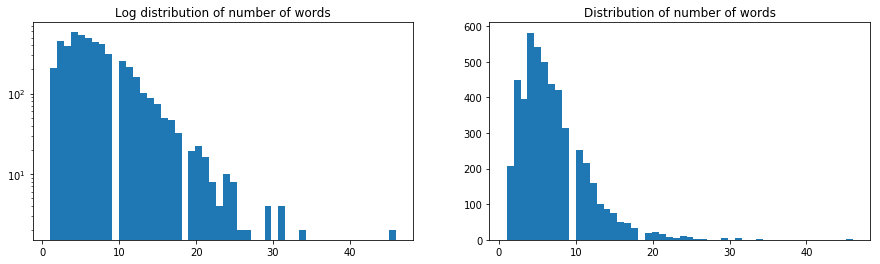

In [78]:
f = plt.figure(figsize=(15, 4))

ax = plt.subplot(1, 2, 1)
ax.set_title('Log distribution of number of words')
n, bins, patches = ax.hist(l, 50, log=True)

ax = plt.subplot(1, 2, 2)
ax.set_title('Distribution of number of words')
n, bins, patches = ax.hist(l, 50)

It seems from thoses distributions that `50` is enough.

# Find nearest neighbours

In [79]:
from sklearn.neighbors import NearestNeighbors

In [145]:
def build_nearest_neighbours(tree, k=2):
    """Build and return scikit NearestNeighbors
    along with neighbours_node_list which will
    later be usefull for checking what node
    was mapped to what.
    
    Inputs:
        - anytree
        - number of nearest neighbours
    """

    # Stack and flatten all embeddings
    # from a given tree
    neighbours_node_list = [node for node in PreOrderIter(tree)]
    embeddings = np.array([node.embedding.flatten() for node in PreOrderIter(tree)])

    # Initiate scikit learn NearestNeighbors
    neighbours = NearestNeighbors(
        n_neighbors=k,
        algorithm='ball_tree'
    ).fit(embeddings)

    return neighbours, neighbours_node_list

In [146]:
neighbours, neighbours_node_list = build_nearest_neighbours(tree1, k=5)

In [147]:
def map_entire_tree(tree, neighbours):
    embeddings = np.array([node.embedding.flatten() for node in PreOrderIter(tree)])

    print('Computing KNN...')
    distances, indices = neighbours.kneighbors(embeddings)

    return distances, indices, embeddings

In [148]:
%%time
distances, indices, embeddings = map_entire_tree(tree2, neighbours)

Computing KNN...
CPU times: user 2min 57s, sys: 287 ms, total: 2min 58s
Wall time: 2min 58s


In [149]:
print('Percentage of not directly matched: {:.2f} % ({}/{})'.format(
        distances[distances[:,0] != 0].shape[0] / distances.shape[0] * 100,
        distances[distances[:,0] != 0].shape[0],
        distances.shape[0]
    )
)

Percentage of not directly matched: 5.65 % (140/2478)


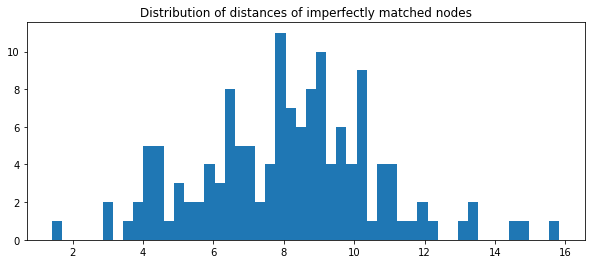

In [156]:
f = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 1, 1)
ax.set_title('Distribution of distances of imperfectly matched nodes')
n, bins, patches = ax.hist(distances[distances[:,0] != 0][:,0], 50)
# n, bins, patches = ax.hist(distances[:,1], 50, alpha=0.5)

## Printing imperfect matches

In [157]:
nodes = np.array([node for node in PreOrderIter(tree2)])
for i in range(indices.shape[0]):
    if distances[i,0] != 0:
        print('{}\n{}\n{}\n'.format(
            nodes[i].name,
            neighbours_node_list[indices[i,0]].name,
            distances[i,0]
        ))

Appui au réseau
Soutien au programme
5.598373650014563

Objectifs de développement durable
Prêts de modernisation
6.9851434710919476

Enseignement supérieur et recherche
Enseignement supérieur
4.236316526081296

Diplomatie économique et développement du tourisme
Développement des entreprises et du tourisme
8.631075429737457

Prévention des violences faites aux femmes, des violences intrafamiliales et l'aide aux victimes
Prévention des violences faites aux femmes, des violences intrafamiliales et aide aux victimes
8.48598908296296

Actions pour améliorer la tranquillité publique
Actions pour améliorer la tranquilité publique
2.947908734906485

Économie et développement durable des entreprises agricoles, agroalimentaires et forestières
Économie et développement durable de l'agriculture et des territoires
9.582981539028848

Emploi et innovation dans les industries agroalimentaires
Emploi des forces
9.714980410716903

Fonds avenir bio
Fonds sociaux
6.726426269213311

Intervention en faveur